# Soft-DTW Divergences – experiment setup

## Imports

Folders setup

In [1]:
import sys
from pathlib import Path

REPO_ROOT = Path.cwd()
if not (REPO_ROOT / 'sdtw_div').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

DATA_DIR = REPO_ROOT / 'data'
DATA_DIR.mkdir(parents=True, exist_ok=True)

FIGURES_DIR = REPO_ROOT / 'results' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

Core methods + dataset loader.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from aeon.datasets import load_classification
from sdtw_div.numba_ops import (
    barycenter,
    euclidean_mean,
    mean_cost,
    mean_cost_div,
    sharp_sdtw,
    sharp_sdtw_div,
    sdtw,
    sdtw_div,
    sdtw_value_and_grad,
    sdtw_div_value_and_grad,
    sharp_sdtw_value_and_grad,
    sharp_sdtw_div_value_and_grad,
    mean_cost_value_and_grad,
    mean_cost_div_value_and_grad,
    squared_euclidean_cost,
    squared_euclidean_distance,
    sdtw_C,
    sdtw_grad_C,
)

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    def tqdm(x, **kwargs):
        return x
import time


Quick helper function to save the figures.

In [3]:
def save_fig(name):
    plt.savefig(FIGURES_DIR / name, dpi=200, bbox_inches="tight")

## Load a dataset
UCR ItalyPowerDemand, as a quick baseline for the first experiments.


In [4]:
X_te, y_te, meta_data = load_classification(
    'ItalyPowerDemand',
    split='test',
    return_metadata=True,
    extract_path=str(DATA_DIR)
)
X_tr, y_tr, _ = load_classification(
    'ItalyPowerDemand',
    split='train',
    return_metadata=True,
    extract_path=str(DATA_DIR)
)
X_tr.shape, X_te.shape


((67, 1, 24), (1029, 1, 24))

## Checking data
One train and one test series.


In [5]:
X_tr[0].shape

(1, 24)

The data will require a transpose operation to be unidimensional.

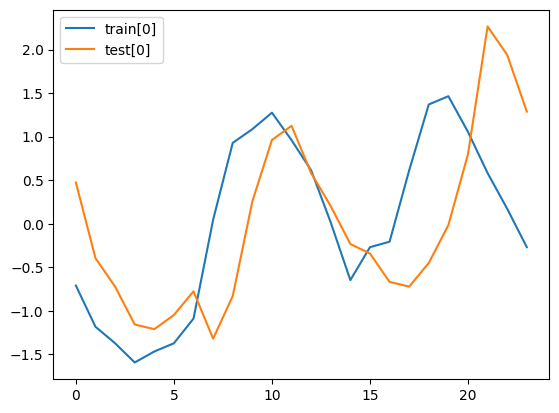

In [8]:
plt.plot(X_tr[0].ravel(), label='train[0]')
plt.plot(X_te[0].ravel(), label='test[0]')
plt.legend()
plt.show()


### Sample a small subset from one class


In [12]:
n = 10
rng = np.random.default_rng(42)
classes = np.unique(y_tr)
k = rng.integers(0, len(classes))
X_a = X_tr[y_tr == classes[k]]
X_aa = X_a[rng.permutation(X_a.shape[0])[:n]]
X_aa = X_aa.swapaxes(1, 2)


### Visualize the subset


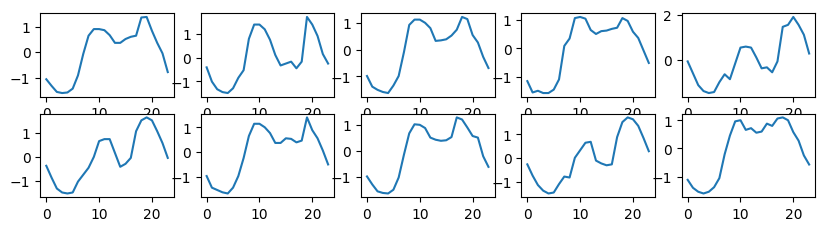

In [13]:
fig = plt.figure(figsize=(10, 5))
for i in range(n):
    ax = fig.add_subplot(4, 5, i + 1)
    ax.plot(X_aa[i].ravel())
save_fig("subset_grid.png")
plt.show()


## Barycenter vs gamma (soft-DTW and soft-DTW divergence)


First experiment: Computing barycenters using function *barycenter(...)*

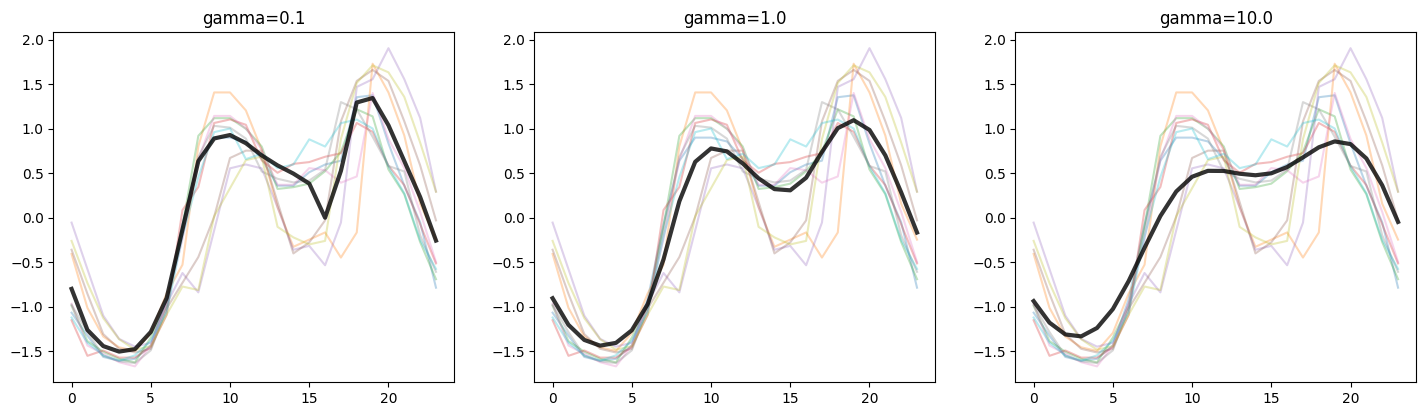

In [14]:
fig = plt.figure(figsize=(30, 10))
for i, gamma in enumerate([0.1, 1.0, 10.0]):
    ax = fig.add_subplot(2, 5, i + 1)
    for x in X_aa:
        ax.plot(x.ravel(), alpha=0.3)
    value_and_grad = lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    Z = barycenter(X_aa, X_init='euclidean_mean', value_and_grad=value_and_grad)
    ax.plot(Z.ravel(), color='k', linewidth=3, alpha=0.8)
    ax.set_title(f'gamma={gamma}')

save_fig("barycenter_vs_gamma.png")
plt.show()


Now for the soft-DTW divergence

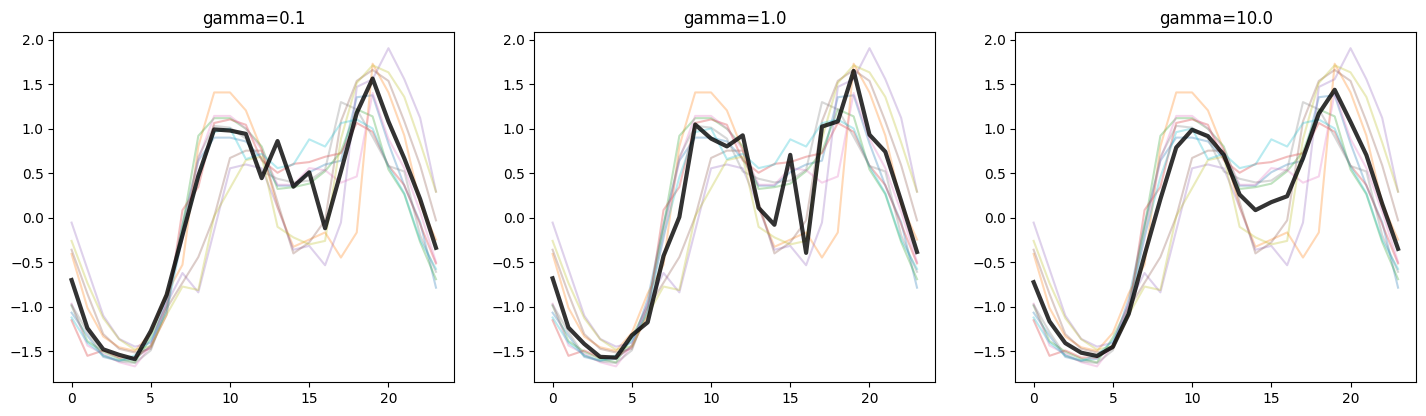

In [15]:
fig = plt.figure(figsize=(30, 10))
for i, gamma in enumerate([0.1, 1.0, 10.0]):
    ax = fig.add_subplot(2, 5, i + 1)
    for x in X_aa:
        ax.plot(x.ravel(), alpha=0.3)
    value_and_grad = lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
    Z = barycenter(X_aa, X_init='euclidean_mean', value_and_grad=value_and_grad)
    ax.plot(Z.ravel(), color='k', linewidth=3, alpha=0.8)
    ax.set_title(f'gamma={gamma}')

save_fig("barycenter_vs_gamma_divergence.png")
plt.show()


Next, we're gonna use more measures.

## Barycenter comparison (Euclidean vs soft-DTW vs divergences)


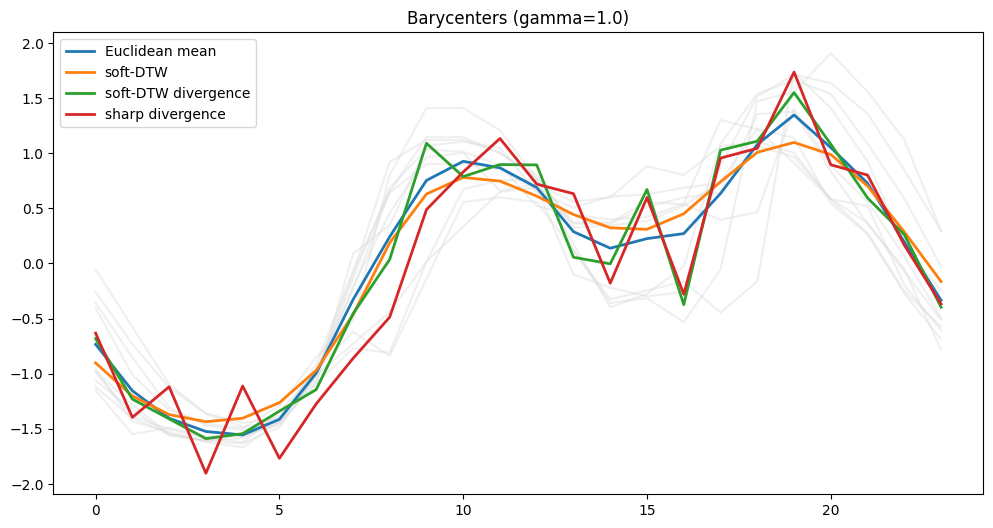

In [16]:
gamma = 1.0

X_euc = euclidean_mean(X_aa)
X_sdtw = barycenter(
    X_aa,
    X_init=X_euc,
    value_and_grad=lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma),
)
X_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
)
X_sharp_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sharp_sdtw_div_value_and_grad(X, Y, gamma=gamma),
)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
for x in X_aa:
    ax.plot(x.ravel(), color='0.85', alpha=0.4)
ax.plot(X_euc.ravel(), label='Euclidean mean', linewidth=2)
ax.plot(X_sdtw.ravel(), label='soft-DTW', linewidth=2)
ax.plot(X_div.ravel(), label='soft-DTW divergence', linewidth=2)
ax.plot(X_sharp_div.ravel(), label='sharp divergence', linewidth=2)
ax.set_title(f'Barycenters (gamma={gamma})')
ax.legend()
save_fig("barycenters_gamma1.png")
plt.show()


Now with a higher $\gamma$

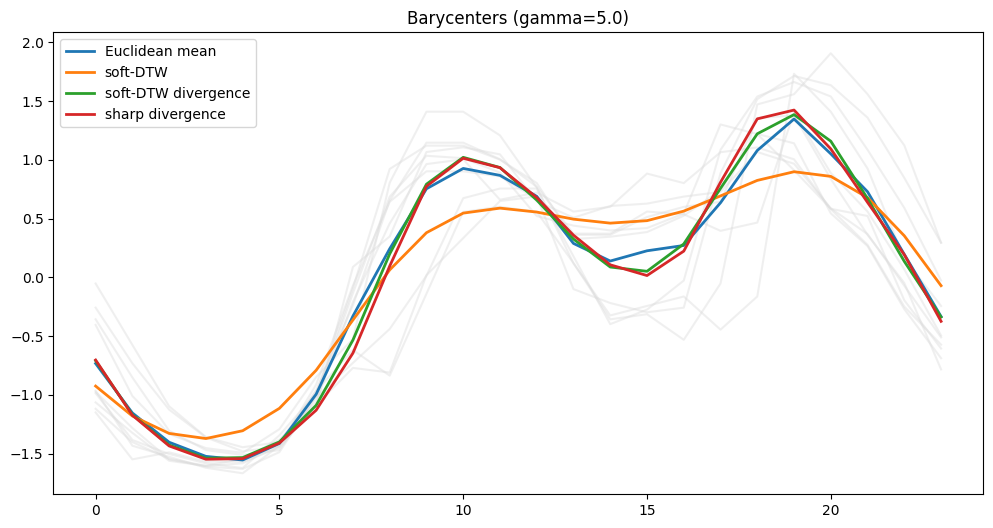

In [17]:
gamma = 5.0

X_euc = euclidean_mean(X_aa)
X_sdtw = barycenter(
    X_aa,
    X_init=X_euc,
    value_and_grad=lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma),
)
X_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
)
X_sharp_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sharp_sdtw_div_value_and_grad(X, Y, gamma=gamma),
)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
for x in X_aa:
    ax.plot(x.ravel(), color='0.85', alpha=0.4)
ax.plot(X_euc.ravel(), label='Euclidean mean', linewidth=2)
ax.plot(X_sdtw.ravel(), label='soft-DTW', linewidth=2)
ax.plot(X_div.ravel(), label='soft-DTW divergence', linewidth=2)
ax.plot(X_sharp_div.ravel(), label='sharp divergence', linewidth=2)
ax.set_title(f'Barycenters (gamma={gamma})')
ax.legend()
save_fig("barycenters_gamma5.png")
plt.show()


## Bias demo (soft-DTW vs divergence)
Minimize over X for a fixed Y.


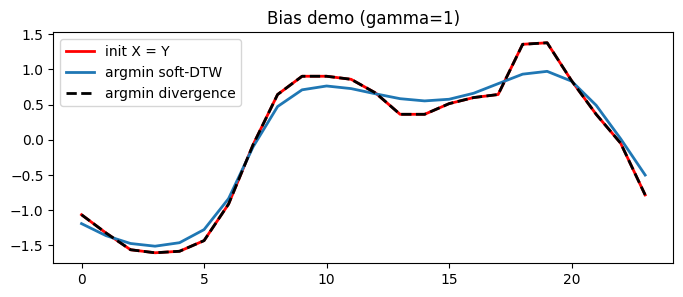

In [12]:
Y = X_aa[0]
X0 = Y.copy()

gamma = 1

X_sdtw = barycenter(
    [Y],
    X_init=X0,
    value_and_grad=lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma),
    tol=1e-9,
    max_iter=200,
)
X_div = barycenter(
    [Y],
    X_init=X0,
    value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
    tol=1e-9,
    max_iter=200,
)

plt.figure(figsize=(8, 3))
plt.plot(X0.ravel(), label='init X = Y', color='red', linewidth=2)
plt.plot(X_sdtw.ravel(), label='argmin soft-DTW', linewidth=2)
plt.plot(X_div.ravel(), label='argmin divergence', linestyle='--', color='black', linewidth=2)
plt.title(f'Bias demo (gamma={gamma})')
plt.legend()
save_fig("bias_demo_gamma_1.png")
plt.show()


Now trying with $\gamma=5$

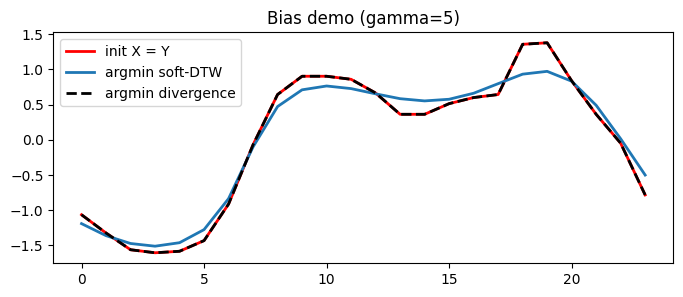

In [13]:
Y = X_aa[0]
X0 = Y.copy()

gamma = 5

plt.figure(figsize=(8, 3))
plt.plot(X0.ravel(), label='init X = Y', color='red', linewidth=2)
plt.plot(X_sdtw.ravel(), label='argmin soft-DTW', linewidth=2)
plt.plot(X_div.ravel(), label='argmin divergence', linestyle='--', color='black', linewidth=2)
plt.title(f'Bias demo (gamma={gamma})')
plt.legend()
save_fig("bias_demo_gamma_5.png")
plt.show()


The argmin of the sdtw divergence is the original time serie.

## Interpolation via weighted barycenters (all methods)
Reproduce the qualitative ``interpolation'' experiment from the paper: given two series $Y_1$ and $Y_2$,
compute barycenters with weights $(\pi, 1-\pi)$ for several $\pi$.
We generate one subplot per discrepancy to compare the interpolation behavior.


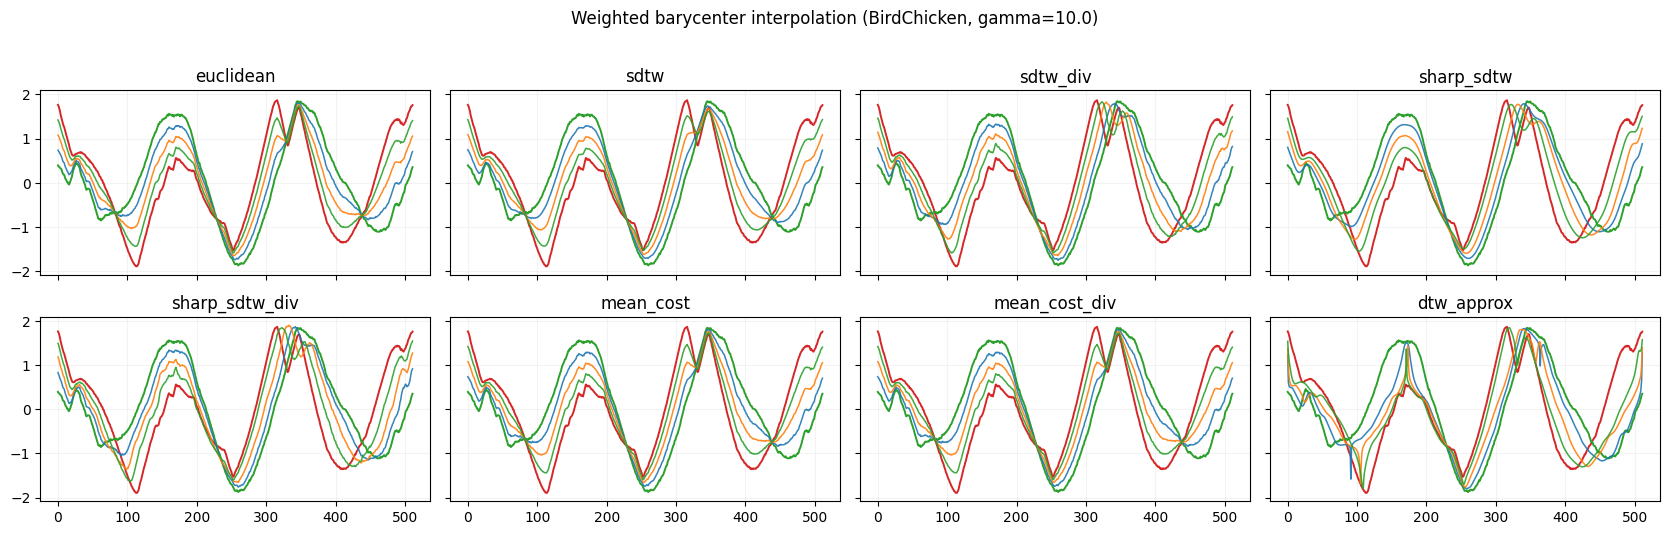

In [14]:
def _interp_value_and_grad(method, gamma):
    if method == 'sdtw':
        return lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    if method == 'sdtw_div':
        return lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
    if method == 'sharp_sdtw':
        return lambda X, Y: sharp_sdtw_value_and_grad(X, Y, gamma=gamma)
    if method == 'sharp_sdtw_div':
        return lambda X, Y: sharp_sdtw_div_value_and_grad(X, Y, gamma=gamma)
    if method == 'mean_cost':
        return mean_cost_value_and_grad
    if method == 'mean_cost_div':
        return mean_cost_div_value_and_grad
    if method == 'dtw_approx':
        return lambda X, Y: sdtw_value_and_grad(X, Y, gamma=0.1)
    raise ValueError(f'Unknown method: {method}')


def plot_interpolation_all_methods(
    dataset_name='ArrowHead',
    idx1=0,
    idx2=1,
    pis=(0.25, 0.5, 0.75),
    gamma=10.0,
    methods=('euclidean', 'sdtw', 'sdtw_div', 'sharp_sdtw', 'sharp_sdtw_div', 'mean_cost', 'mean_cost_div', 'dtw_approx'),
):
    X_tr, y_tr, _ = load_classification(
        dataset_name,
        split='train',
        return_metadata=True,
        extract_path=str(DATA_DIR),
    )
    # aeon often returns (n, 1, T); convert to (n, T, 1)
    if X_tr.ndim == 3 and X_tr.shape[1] == 1:
        X_tr = X_tr.swapaxes(1, 2)

    Y1 = X_tr[idx1]
    Y2 = X_tr[idx2]

    ncols = 4
    nrows = int(np.ceil(len(methods) / ncols))
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(4.2 * ncols, 2.6 * nrows),
        sharex=True,
        sharey=True,
    )
    axes = np.atleast_1d(axes).ravel()

    for ax_idx, method in enumerate(methods):
        ax = axes[ax_idx]
        ax.plot(Y1.ravel(), color='tab:red', linewidth=1.4)
        ax.plot(Y2.ravel(), color='tab:green', linewidth=1.4)
        for pi in pis:
            Ys = [Y1, Y2]
            weights = np.array([pi, 1.0 - pi])
            X_init = euclidean_mean(Ys, weights=weights)
            if method == 'euclidean':
                Z = euclidean_mean(Ys, weights=weights)
            else:
                valgrad = _interp_value_and_grad(method, gamma)
                Z = barycenter(
                    Ys,
                    X_init=X_init,
                    value_and_grad=valgrad,
                    weights=weights,
                    max_iter=200,
                )
            ax.plot(Z.ravel(), linewidth=1.1, alpha=0.9)
        ax.set_title(method)
        ax.grid(alpha=0.15)

    for j in range(len(methods), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Weighted barycenter interpolation ({dataset_name}, gamma={gamma})', y=1.02)
    fig.tight_layout()
    save_fig(f"{dataset_name}_interp_all_methods.png")
    plt.show()


plot_interpolation_all_methods('BirdChicken', gamma=10.0)


## DTW baseline


In [15]:
from sdtw_div.dtw_baseline import dtw_distance

try:
    d = dtw_distance(X_aa[0].ravel(), X_aa[1].ravel(), backend='dtaidistance')
    print('DTW distance (dtaidistance):', d)
except ModuleNotFoundError as e:
    print('DTW backend not installed:', e)


DTW distance (dtaidistance): DtwResult(distance=2.2297407918728798, backend='dtaidistance')


We won't really use this function later, since it's not differentiable, but we will approximate it using $\gamma=0.1$

## Visualize alignement matrix


--- Alignment Sparsity vs Gamma ---


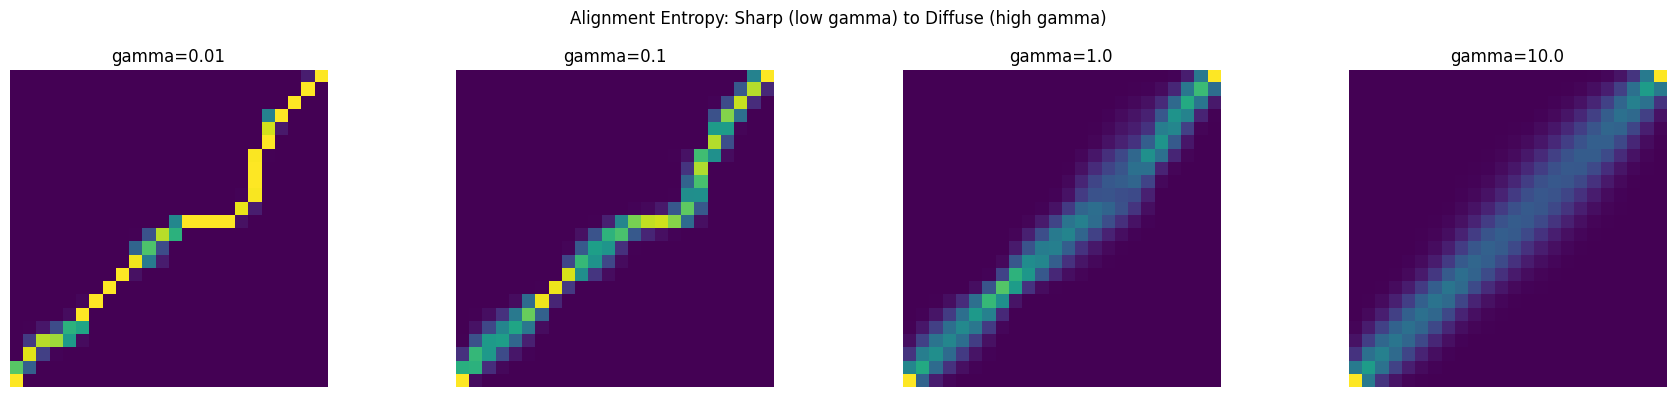

In [16]:
def experiment_gamma_alignment_sparsity(X_train):
    """
    Visualize alignment matrices for a pair of series across gamma values.
    """
    print("\n--- Alignment Sparsity vs Gamma ---")

    X = X_train[0]
    Y = X_train[1]
    gammas = [0.01, 0.1, 1.0, 10.0]

    fig, axes = plt.subplots(1, len(gammas), figsize=(18, 4))
    for i, g in enumerate(gammas):
        C = squared_euclidean_cost(X, Y)
        _, P_tensor = sdtw_C(C, gamma=g, return_all=True)
        E = sdtw_grad_C(P_tensor)

        axes[i].imshow(E, origin='lower', cmap='viridis', vmin=0, vmax=1)
        axes[i].set_title(f"gamma={g}")
        axes[i].axis('off')

    plt.suptitle("Alignment Entropy: Sharp (low gamma) to Diffuse (high gamma)")
    plt.tight_layout()
    save_fig("alignment_entropy.png")
    plt.show()

X_tr_T = X_tr.swapaxes(1, 2)
experiment_gamma_alignment_sparsity(X_tr_T)

## Prototype classifier (small-scale)
Train one barycenter per class and classify by nearest prototype. (Just to make sure it works)


In [17]:

X_tr_T = X_tr.swapaxes(1, 2)
X_te_T = X_te.swapaxes(1, 2)

classes = np.unique(y_tr)[:2]
n_train = 6
n_test = 6
gamma = 1.0

def class_subset(X, y, cls, n):
    idx = np.where(y == cls)[0][:n]
    return [X[i] for i in idx]

protos = {}
for cls in classes:
    Ys = class_subset(X_tr_T, y_tr, cls, n_train)
    protos[cls] = barycenter(
        Ys,
        X_init='euclidean_mean',
        value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
        max_iter=100,
    )

def predict(x, dist_fn):
    best_cls, best_dist = None, float('inf')
    for cls, proto in protos.items():
        d = dist_fn(x, proto)
        if d < best_dist:
            best_dist, best_cls = d, cls
    return best_cls

X_test = []
y_test = []
for cls in classes:
    Xc = class_subset(X_te_T, y_te, cls, n_test)
    X_test.extend(Xc)
    y_test.extend([cls] * len(Xc))

pred_sdtw = [predict(x, lambda a, b: sdtw(a, b, gamma=gamma)) for x in X_test]
pred_div = [predict(x, lambda a, b: sdtw_div(a, b, gamma=gamma)) for x in X_test]

acc_sdtw = np.mean([p == y for p, y in zip(pred_sdtw, y_test)])
acc_div = np.mean([p == y for p, y in zip(pred_div, y_test)])
print(f'Prototype accuracy (soft-DTW): {acc_sdtw:.3f}')
print(f'Prototype accuracy (divergence): {acc_div:.3f}')


Prototype accuracy (soft-DTW): 0.917
Prototype accuracy (divergence): 0.917


## Method registry
List all methods so we can pick a subset.


In [18]:
METHODS = {
    'euclidean': {'type': 'mean'},
    'sdtw': {'type': 'barycenter', 'value_and_grad': 'sdtw_value_and_grad'},
    'sdtw_div': {'type': 'barycenter', 'value_and_grad': 'sdtw_div_value_and_grad'},
    'sharp_sdtw': {'type': 'barycenter', 'value_and_grad': 'sharp_sdtw_value_and_grad'},
    'sharp_sdtw_div': {'type': 'barycenter', 'value_and_grad': 'sharp_sdtw_div_value_and_grad'},
    'mean_cost': {'type': 'barycenter', 'value_and_grad': 'mean_cost_value_and_grad'},
    'mean_cost_div': {'type': 'barycenter', 'value_and_grad': 'mean_cost_div_value_and_grad'},
    'dtw_approx': {'type': 'barycenter', 'value_and_grad': 'sdtw_value_and_grad', 'gamma': 0.1},
}
list(METHODS.keys())


['euclidean',
 'sdtw',
 'sdtw_div',
 'sharp_sdtw',
 'sharp_sdtw_div',
 'mean_cost',
 'mean_cost_div',
 'dtw_approx']

## Choose methods to run


In [20]:
SELECTED_METHODS = [
    'euclidean',
    'sdtw',
    'sdtw_div',
    'sharp_sdtw',
    'sharp_sdtw_div',
    'mean_cost',
    'mean_cost_div',
    'dtw_approx',
]


## List available datasets (UCR/UEA via aeon)


In [24]:
try:
    from aeon.datasets import get_dataset_meta_data
    meta = get_dataset_meta_data()
    datasets = sorted(meta['Dataset'].tolist())
    print('Number of datasets:', len(datasets))
    print(datasets[:20])
except Exception as e:
    print('Could not list datasets via aeon:', e)


Number of datasets: 190
['ACSF1', 'AbnormalHeartbeat', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'ArticularyWordRecognition', 'AsphaltObstacles', 'AsphaltObstaclesCoordinates', 'AsphaltPavementType', 'AsphaltPavementTypeCoordinates', 'AsphaltRegularity', 'AsphaltRegularityCoordinates', 'AtrialFibrillation', 'BME', 'BasicMotions', 'Beef', 'BeetleFly', 'BinaryHeartbeat']


In [25]:
get_dataset_meta_data()[:10]

,Dataset,TrainSize,TestSize,Length,NumberClasses,Type,Channels
0,Adiac,390,391,176,37,IMAGE,1
1,ArrowHead,36,175,251,3,IMAGE,1
2,Beef,30,30,470,5,SPECTRO,1
3,BeetleFly,20,20,512,2,IMAGE,1
4,BirdChicken,20,20,512,2,IMAGE,1
5,Car,60,60,577,4,SENSOR,1
6,CBF,30,900,128,3,SIMULATED,1
7,ChlorineConcentration,467,3840,166,3,SIMULATED,1
8,CinCECGTorso,40,1380,1639,4,ECG,1
9,Coffee,28,28,286,2,SPECTRO,1


As a first filter, we're gonna remove multivariate time series.

## Batch evaluation across datasets
Compute prototype-classifier accuracy for each method and dataset.


Second filter, remove all the datasets that took too long (early-stopped manually). We excluded them to help easy reproducibility.

In [26]:
datasets_to_exclude = {"CinCECGTorso", "Computers", "ElectricDevices", 
                       "FiftyWords", "FordA", "FordB", "HandOutlines", 
                       "Haptics", "LargeKitchenAppliances", "InlineSkate", "Mallat",
                       "NonInvasiveFetalECGThorax1", "NonInvasiveFetalECGThorax2", "Phoneme",
                       "RefrigerationDevices", "ScreenType", "ShapesAll",
                       "SmallKitchenAppliances", "StarLightCurves",
                       "UWaveGestureLibraryAll", "UWaveGestureLibraryX", "UWaveGestureLibraryY",
                       "UWaveGestureLibraryZ", "Worms", "WormsTwoClass", "Yoga", "ACSF1",
                       "AllGestureWiimoteX", "AllGestureWiimoteY", "AllGestureWiimoteZ",
                       "EthanolLevel", "ACSF1", "PigAirwayPressure", "PigArtPressure",
                       "PigCVP", "PLAID", "GesturePebbleZ1","GesturePebbleZ2",
                       "HouseTwenty", "SemgHandGenderCh2", "SemgHandMovementCh2",
                       "SemgHandSubjectCh2", "MixedShapes", "MixedShapesSmallTrain", "EOGHorizontalSignal",
                       "EOGVerticalSignal", "GestureMidAirD1", "GestureMidAirD2", "GestureMidAirD3",
                       "Crop", "Rock", "AsphaltObstacles", "AsphaltPavementType", "AsphaltRegularity",
                       "AsphaltRegularityCoordinates", "RightWhaleCalls", "CatsDogs", "BinaryHeartbeat",
                       "DucksAndGeese", "UrbanSound", "FruitFlies", "InsectSound", "MosquitoSound", "AbnormalHeartbeat",
                       "KeplerLightCurves", "Sleep", "FaultDetectionA", "FaultDetectionB", "NerveDamage", "CardiacArrhythmia"} # Takes too much time

In [27]:
MAX_DATASETS = None
MAX_TRAIN_PER_CLASS = None
MAX_TEST_PER_CLASS = None
GAMMA = 1.0
MAX_SDTW_RUNTIME = 50.0  # seconds

def _fix_shape(X):
    # aeon often returns (n, 1, T); convert to (n, T, 1), as said earlier in data exploration
    if X.ndim == 3 and X.shape[1] == 1:
        return X.swapaxes(1, 2)
    return X

def _subset_class(X, y, cls, n, seed=0):
    idx = np.where(y == cls)[0]
    if n is None or len(idx) <= n:
        return [X[i] for i in idx]
    rng = np.random.default_rng(seed)
    idx = rng.permutation(idx)[:n]
    return [X[i] for i in idx]

def _method_value_and_grad(method, gamma):
    if method == 'sdtw':
        return lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    if method == 'sdtw_div':
        return lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
    if method == 'sharp_sdtw':
        return lambda X, Y: sharp_sdtw_value_and_grad(X, Y, gamma=gamma)
    if method == 'sharp_sdtw_div':
        return lambda X, Y: sharp_sdtw_div_value_and_grad(X, Y, gamma=gamma)
    if method == 'mean_cost':
        return mean_cost_value_and_grad
    if method == 'mean_cost_div':
        return mean_cost_div_value_and_grad
    if method == 'dtw_approx':
        return lambda X, Y: sdtw_value_and_grad(X, Y, gamma=0.1)
    return None

def _method_distance(method, x, y, gamma):
    if method == 'euclidean':
        return squared_euclidean_distance(x, y)
    if method == 'sdtw':
        return sdtw(x, y, gamma=gamma)
    if method == 'sdtw_div':
        return sdtw_div(x, y, gamma=gamma)
    if method == 'sharp_sdtw':
        return sharp_sdtw(x, y, gamma=gamma)
    if method == 'sharp_sdtw_div':
        return sharp_sdtw_div(x, y, gamma=gamma)
    if method == 'mean_cost':
        return mean_cost(x, y)
    if method == 'mean_cost_div':
        return mean_cost_div(x, y)
    if method == 'dtw_approx':
        return sdtw(x, y, gamma=0.1)
    raise ValueError(f'Unknown method: {method}')

def compute_prototypes(method, X_train, y_train, gamma):
    protos = {}
    for cls in np.unique(y_train):
        Ys = _subset_class(X_train, y_train, cls, MAX_TRAIN_PER_CLASS, seed=0)
        if method == 'euclidean':
            protos[cls] = euclidean_mean(Ys)
        else:
            valgrad = _method_value_and_grad(method, gamma)
            protos[cls] = barycenter(
                Ys,
                X_init='euclidean_mean',
                value_and_grad=valgrad,
                max_iter=100,
            )
    return protos

def classify_with_prototypes(method, protos, X_test, y_test, gamma):
    preds = []
    for x in X_test:
        best_cls, best_dist = None, float('inf')
        for cls, proto in protos.items():
            d = _method_distance(method, x, proto, gamma)
            if d < best_dist:
                best_dist, best_cls = d, cls
        preds.append(best_cls)
    acc = np.mean([p == y for p, y in zip(preds, y_test)])
    return float(acc)


def filter_datasets(meta_df):
    df = meta_df.copy()
    if 'Channels' in df.columns:
        df = df[df['Channels'] == 1]
    df = df[~df['Dataset'].isin(datasets_to_exclude)]
    return df

RESULTS_PATH = REPO_ROOT / 'results' / 'prototype_results.csv'
RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)

if RESULTS_PATH.exists():
    try:
        results_df = pd.read_csv(RESULTS_PATH)
        results = results_df.to_dict('records')
        done_pairs = set(zip(results_df['dataset'], results_df['method']))
        print('Resuming from', RESULTS_PATH, 'with', len(done_pairs), 'rows')
    except pd.errors.EmptyDataError:
        results = []
        done_pairs = set()
        print('Found empty results file; starting fresh.')
else:
    results = []
    done_pairs = set()

try:
    meta = get_dataset_meta_data()
    meta = filter_datasets(meta)
    dataset_list = meta['Dataset'].tolist()
except Exception as e:
    print('Could not load metadata for filtering:', e)
    dataset_list = datasets

if MAX_DATASETS is not None:
    dataset_list = dataset_list[:MAX_DATASETS]

for ds_idx, dataset_name in enumerate(dataset_list, start=1):
    try:
        if all((dataset_name, m) in done_pairs for m in SELECTED_METHODS):
            print(f"Skipping {dataset_name} (already complete)")
            continue
        X_te, y_te, _ = load_classification(
            dataset_name,
            split='test',
            return_metadata=True,
            extract_path=str(DATA_DIR),
        )
        X_tr, y_tr, _ = load_classification(
            dataset_name,
            split='train',
            return_metadata=True,
            extract_path=str(DATA_DIR),
        )
        X_tr = _fix_shape(X_tr)
        X_te = _fix_shape(X_te)

        if MAX_TEST_PER_CLASS is not None:
            X_test = []
            y_test = []
            for cls in np.unique(y_te):
                Xc = _subset_class(X_te, y_te, cls, MAX_TEST_PER_CLASS, seed=1)
                X_test.extend(Xc)
                y_test.extend([cls] * len(Xc))
        else:
            X_test = [x for x in X_te]
            y_test = list(y_te)

        skip_dataset = False
        for method in tqdm(SELECTED_METHODS, desc=f'[{ds_idx}/{len(dataset_list)}] {dataset_name} | train={len(X_tr)}'):
            if (dataset_name, method) in done_pairs:
                continue
            t0 = time.time()
            protos = compute_prototypes(method, X_tr, y_tr, GAMMA)
            acc = classify_with_prototypes(method, protos, X_test, y_test, GAMMA)
            elapsed = time.time() - t0
            if method == 'sdtw' and elapsed > MAX_SDTW_RUNTIME:
                print(f'Skipping {dataset_name} (sdtw runtime {elapsed:.1f}s)')
                skip_dataset = True
            results.append({
                'dataset': dataset_name,
                'method': method,
                'accuracy': acc,
                'runtime_s': elapsed,
                'train_size': len(X_tr),
                'test_size': len(X_te),
                'n_classes': len(np.unique(y_tr)),
            })
            done_pairs.add((dataset_name, method))
            pd.DataFrame(results).to_csv(RESULTS_PATH, index=False)
            if skip_dataset:
                break
    except Exception as e:
        print('Skipping', dataset_name, '->', e)

results_df = pd.DataFrame(results)
results_df.head()


Resuming from /home/acepeax/Desktop/Studies/MVA/TimeSeries/Soft_DTW_div_project/results/prototype_results.csv with 732 rows
Skipping Adiac (already complete)
Skipping ArrowHead (already complete)
Skipping Beef (already complete)
Skipping BeetleFly (already complete)
Skipping BirdChicken (already complete)
Skipping Car (already complete)
Skipping CBF (already complete)
Skipping ChlorineConcentration (already complete)
Skipping Coffee (already complete)
Skipping CricketX (already complete)
Skipping CricketY (already complete)
Skipping CricketZ (already complete)
Skipping DiatomSizeReduction (already complete)
Skipping DistalPhalanxOutlineAgeGroup (already complete)
Skipping DistalPhalanxOutlineCorrect (already complete)
Skipping DistalPhalanxTW (already complete)
Skipping Earthquakes (already complete)
Skipping ECG200 (already complete)
Skipping ECG5000 (already complete)
Skipping ECGFiveDays (already complete)
Skipping FaceAll (already complete)
Skipping FaceFour (already complete)
Skip

,dataset,method,accuracy,runtime_s,train_size,test_size,n_classes
0,Adiac,euclidean,0.549872,0.070505,390,391,37
1,Adiac,sdtw,0.639386,16.210004,390,391,37
2,Adiac,sdtw_div,0.672634,49.080930,390,391,37
3,Adiac,sharp_sdtw,0.667519,20.199450,390,391,37
4,Adiac,sharp_sdtw_div,0.672634,59.955005,390,391,37


## Summary tables
A beats B if accuracy(A) >= 0.99 * accuracy(B).


In [28]:
results_df = pd.read_csv(RESULTS_PATH)

methods = SELECTED_METHODS
counts = results_df.groupby('dataset')['method'].nunique()
complete_datasets = counts[counts == len(methods)].index
filtered = results_df[results_df['dataset'].isin(complete_datasets)]

# Mean accuracy per method (only complete datasets)
mean_table = (
    filtered.groupby('method')['accuracy']
    .mean()
    .reindex(methods)
    .sort_values(ascending=False)
)
print(mean_table)

# Win counts using paper rule: A >= 0.99 * B
pivot = filtered.pivot_table(index='dataset', columns='method', values='accuracy')
win_counts = pd.DataFrame(0, index=methods, columns=methods)
for a in methods:
    for b in methods:
        if a == b:
            continue
        win_counts.loc[a, b] = (pivot[a] >= 0.99 * pivot[b]).sum()
win_pct = (win_counts / len(pivot.index)) * 100
print(win_pct.round(1))


method
dtw_approx        0.733664
sharp_sdtw_div    0.731488
sdtw_div          0.730958
sharp_sdtw        0.716484
sdtw              0.708765
euclidean         0.663885
mean_cost_div     0.531735
mean_cost         0.525879
Name: accuracy, dtype: float64
                euclidean  sdtw  sdtw_div  sharp_sdtw  sharp_sdtw_div  \
euclidean             0.0  46.9      43.2        44.4            42.0   
sdtw                 69.1   0.0      51.9        60.5            49.4   
sdtw_div             75.3  90.1       0.0        77.8            76.5   
sharp_sdtw           71.6  69.1      53.1         0.0            60.5   
sharp_sdtw_div       72.8  76.5      67.9        86.4             0.0   
mean_cost            43.2  25.9      22.2        25.9            24.7   
mean_cost_div        46.9  32.1      28.4        29.6            27.2   
dtw_approx           71.6  79.0      64.2        80.2            70.4   

                mean_cost  mean_cost_div  dtw_approx  
euclidean            76.5        

In [ ]:
mean_runtime_s = (
    filtered.groupby('method')['runtime_s']
    .mean()
    .reindex(methods)
    .sort_values(ascending=True)
)
print(mean_runtime_s)

# Mean runtime normalized by Euclidean
pivot_runtime = filtered.pivot_table(index='dataset', columns='method', values='runtime_s')
euclid_rt = pivot_runtime['euclidean'].replace(0, np.nan)
runtime_ratio = pivot_runtime.div(euclid_rt, axis=0)
mean_runtime_ratio = runtime_ratio.mean(axis=0).reindex(methods).sort_values(ascending=True)
print(mean_runtime_ratio)

method
euclidean          0.025737
mean_cost          5.141994
sdtw               7.869649
dtw_approx        11.842868
mean_cost_div     14.261204
sharp_sdtw        15.679561
sdtw_div          38.029078
sharp_sdtw_div    73.393691
Name: runtime_s, dtype: float64
method
euclidean             1.000000
sdtw               1122.448245
mean_cost          1694.528772
dtw_approx         2091.994108
sharp_sdtw         3396.639325
mean_cost_div      4906.277265
sdtw_div           7689.072988
sharp_sdtw_div    17835.957930
dtype: float64


## Convert to LaTeX


In [ ]:
def format_method_name(s):
    return " ".join(part.capitalize() for part in s.split("_"))

latex_mean = mean_table.reset_index().rename(
        columns={'method': 'Method', 'accuracy': 'MeanAcc'}
    ).assign(Method=lambda df: df['Method'].apply(format_method_name))\
    .to_latex(index=False, float_format='%.3f')

latex_runtime = mean_runtime_s.reset_index().rename(
        columns={'method': 'Method', 'runtime_s': 'MeanRuntimeSec'}
    ).assign(Method=lambda df: df['Method'].apply(format_method_name))\
    .to_latex(index=False, float_format='%.2f')

latex_runtime_ratio = mean_runtime_ratio.reset_index().rename(
        columns={'method': 'Method', 0: 'MeanRuntimeOverEuclidean'}
    )

if 'MeanRuntimeOverEuclidean' not in latex_runtime_ratio.columns:
    ratio_col = [c for c in latex_runtime_ratio.columns if c != 'Method'][0]
    latex_runtime_ratio = latex_runtime_ratio.rename(columns={ratio_col: 'MeanRuntimeOverEuclidean'})
latex_runtime_ratio = latex_runtime_ratio.assign(
        Method=lambda df: df['Method'].apply(format_method_name)
    ).to_latex(index=False, float_format='%.2f')

latex_wins = win_pct.round(1).rename(
        index=format_method_name,
        columns=format_method_name,
    ).to_latex(float_format="%.1f")

print(latex_mean)
print(latex_runtime)
print(latex_runtime_ratio)
print(latex_wins)

\begin{tabular}{lr}
\toprule
Method & MeanAcc \\
\midrule
Dtw Approx & 0.734 \\
Sharp Sdtw Div & 0.731 \\
Sdtw Div & 0.731 \\
Sharp Sdtw & 0.716 \\
Sdtw & 0.709 \\
Euclidean & 0.664 \\
Mean Cost Div & 0.532 \\
Mean Cost & 0.526 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
Method & MeanRuntimeSec \\
\midrule
Euclidean & 0.03 \\
Mean Cost & 5.14 \\
Sdtw & 7.87 \\
Dtw Approx & 11.84 \\
Mean Cost Div & 14.26 \\
Sharp Sdtw & 15.68 \\
Sdtw Div & 38.03 \\
Sharp Sdtw Div & 73.39 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
Method & MeanRuntimeOverEuclidean \\
\midrule
Euclidean & 1.00 \\
Sdtw & 1122.45 \\
Mean Cost & 1694.53 \\
Dtw Approx & 2091.99 \\
Sharp Sdtw & 3396.64 \\
Mean Cost Div & 4906.28 \\
Sdtw Div & 7689.07 \\
Sharp Sdtw Div & 17835.96 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrr}
\toprule
 & Euclidean & Sdtw & Sdtw Div & Sharp Sdtw & Sharp Sdtw Div & Mean Cost & Mean Cost Div & Dtw Approx \\
\midrule
Euclidean & 0.0 & 46.9 & 43.2 & 44.4 & 42

## Batch evaluation: divergence methods vs. $\gamma$
We repeat the large-scale benchmark but only for the two debiased divergences
(soft-DTW divergence and sharp divergence) while sweeping $\gamma$.

In [ ]:
DIVERGENCE_METHODS = ['sdtw_div', 'sharp_sdtw_div']
GAMMA_SWEEP = [0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
RESULTS_PATH_SWEEP = REPO_ROOT / 'results' / 'prototype_results_divergences_gamma.csv'
RESULTS_PATH_SWEEP.parent.mkdir(parents=True, exist_ok=True)

if RESULTS_PATH_SWEEP.exists():
    try:
        sweep_df = pd.read_csv(RESULTS_PATH_SWEEP)
        sweep_results = sweep_df.to_dict('records')
        done_triples = set((d, m, float(g)) for d, m, g in zip(sweep_df['dataset'], sweep_df['method'], sweep_df['gamma']))
        print('Resuming from', RESULTS_PATH_SWEEP, 'with', len(done_triples), 'rows')
    except pd.errors.EmptyDataError:
        sweep_results = []
        done_triples = set()
        print('Found empty sweep results file; starting fresh.')
else:
    sweep_results = []
    done_triples = set()

try:
    meta = get_dataset_meta_data()
    meta = filter_datasets(meta)
    dataset_list_sweep = meta['Dataset'].tolist()
except Exception as e:
    print('Could not load metadata for filtering (sweep):', e)
    dataset_list_sweep = dataset_list

MAX_DATASETS_SWEEP = None
if MAX_DATASETS_SWEEP is not None:
    dataset_list_sweep = dataset_list_sweep[:MAX_DATASETS_SWEEP]

for ds_idx, dataset_name in enumerate(dataset_list_sweep, start=1):
    try:
        if all((dataset_name, m, g) in done_triples for m in DIVERGENCE_METHODS for g in GAMMA_SWEEP):
            print(f"Skipping {dataset_name} (divergence sweep already complete)")
            continue

        X_te, y_te, _ = load_classification(
            dataset_name,
            split='test',
            return_metadata=True,
            extract_path=str(DATA_DIR),
        )
        X_tr, y_tr, _ = load_classification(
            dataset_name,
            split='train',
            return_metadata=True,
            extract_path=str(DATA_DIR),
        )
        X_tr = _fix_shape(X_tr)
        X_te = _fix_shape(X_te)

        if MAX_TEST_PER_CLASS is not None:
            X_test = []
            y_test = []
            for cls in np.unique(y_te):
                Xc = _subset_class(X_te, y_te, cls, MAX_TEST_PER_CLASS, seed=1)
                X_test.extend(Xc)
                y_test.extend([cls] * len(Xc))
        else:
            X_test = [x for x in X_te]
            y_test = list(y_te)

        tasks = [(m, g) for g in GAMMA_SWEEP for m in DIVERGENCE_METHODS]
        for method, gamma in tqdm(
            tasks,
            desc=f'[{ds_idx}/{len(dataset_list_sweep)}] {dataset_name} | train={len(X_tr)}',
        ):
            if (dataset_name, method, gamma) in done_triples:
                continue

            t0 = time.time()
            protos = compute_prototypes(method, X_tr, y_tr, gamma)
            acc = classify_with_prototypes(method, protos, X_test, y_test, gamma)
            elapsed = time.time() - t0

            sweep_results.append({
                'dataset': dataset_name,
                'method': method,
                'gamma': float(gamma),
                'accuracy': float(acc),
                'runtime_s': float(elapsed),
                'train_size': len(X_tr),
                'test_size': len(X_te),
                'n_classes': len(np.unique(y_tr)),
            })
            done_triples.add((dataset_name, method, float(gamma)))
            pd.DataFrame(sweep_results).to_csv(RESULTS_PATH_SWEEP, index=False)

            if method == 'sdtw_div' and elapsed > MAX_SDTW_RUNTIME:
                print(f'Skipping {dataset_name} (sdtw_div runtime {elapsed:.1f}s at gamma={gamma})')
                break
    except Exception as e:
        print('Skipping (sweep)', dataset_name, '->', e)


Resuming from /home/acepeax/Desktop/Studies/MVA/TimeSeries/Soft_DTW_div_project/results/prototype_results_divergences_gamma.csv with 972 rows
Skipping Adiac (divergence sweep already complete)
Skipping ArrowHead (divergence sweep already complete)
Skipping Beef (divergence sweep already complete)
Skipping BeetleFly (divergence sweep already complete)
Skipping BirdChicken (divergence sweep already complete)
Skipping Car (divergence sweep already complete)
Skipping CBF (divergence sweep already complete)
Skipping ChlorineConcentration (divergence sweep already complete)
Skipping Coffee (divergence sweep already complete)
Skipping CricketX (divergence sweep already complete)
Skipping CricketY (divergence sweep already complete)
Skipping CricketZ (divergence sweep already complete)
Skipping DiatomSizeReduction (divergence sweep already complete)
Skipping DistalPhalanxOutlineAgeGroup (divergence sweep already complete)
Skipping DistalPhalanxOutlineCorrect (divergence sweep already complete)

Summary: mean accuracy/runtime by (method, gamma) on complete datasets only.

gamma               0.5       1.0       3.0       5.0       7.0       10.0
method                                                                    
sdtw_div        0.164716  0.169145  0.166581  0.171984  0.173956  0.182042
sharp_sdtw_div  0.166528  0.166251  0.171595  0.171583  0.166427  0.169306
Mean accuracy (rows=method, cols=gamma):
gamma               0.5       1.0       3.0      5.0       7.0       10.0
method                                                                   
sdtw_div        0.737133  0.730958  0.721663  0.71540  0.709178  0.702373
sharp_sdtw_div  0.743490  0.731488  0.724983  0.71882  0.721763  0.718122


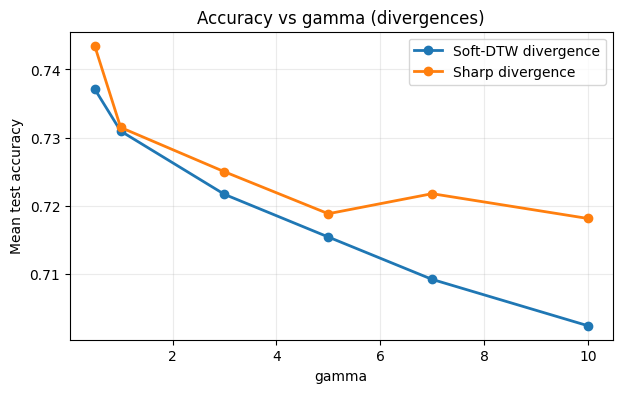

Mean runtime seconds (rows=method, cols=gamma):
gamma                0.5        1.0        3.0        5.0        7.0   \
method                                                                  
sdtw_div        30.870549  29.458342  29.515259  29.089036  29.233243   
sharp_sdtw_div  56.869965  55.094018  52.922264  51.605419  53.342859   

gamma                10.0  
method                     
sdtw_div        26.679081  
sharp_sdtw_div  50.202967  
Win percentages by gamma (paper rule):
       sdtw_div_beats_sharp_sdtw_div  sharp_sdtw_div_beats_sdtw_div
gamma                                                              
0.5                             69.1                           66.7
1.0                             76.5                           67.9
3.0                             61.7                           72.8
5.0                             59.3                           67.9
7.0                             55.6                           76.5
10.0                            

In [ ]:
sweep_df = pd.read_csv(RESULTS_PATH_SWEEP)
sweep_df['gamma'] = sweep_df['gamma'].astype(float)
sweep_df['method_gamma'] = sweep_df['method'].astype(str) + '@' + sweep_df['gamma'].astype(str)

expected = len(DIVERGENCE_METHODS) * len(GAMMA_SWEEP)
counts = sweep_df.groupby('dataset')['method_gamma'].nunique()
complete_datasets = counts[counts == expected].index
sweep_filtered = sweep_df[sweep_df['dataset'].isin(complete_datasets)]

mean_acc_sweep = (
    sweep_filtered.groupby(['method', 'gamma'])['accuracy']
    .mean()
    .unstack('gamma')
    .reindex(index=DIVERGENCE_METHODS, columns=GAMMA_SWEEP)
)

std_acc_sweep = (
    sweep_filtered.groupby(['method', 'gamma'])['accuracy']
    .std()
    .unstack('gamma')
    .reindex(index=DIVERGENCE_METHODS, columns=GAMMA_SWEEP)
)

print(std_acc_sweep)

print('Mean accuracy (rows=method, cols=gamma):')
print(mean_acc_sweep)

plt.figure(figsize=(7, 4))
for method, label in [
    ('sdtw_div', 'Soft-DTW divergence'),
    ('sharp_sdtw_div', 'Sharp divergence'),
]:
    if method not in mean_acc_sweep.index:
        continue
    plt.plot(
        GAMMA_SWEEP,
        mean_acc_sweep.loc[method].values,
        marker='o',
        linewidth=2,
        label=label,
    )
plt.xlabel('gamma')
plt.ylabel('Mean test accuracy')
plt.title('Accuracy vs gamma (divergences)')
plt.grid(alpha=0.25)
plt.legend(loc='best')
save_fig('divergences_accuracy_vs_gamma.png')
plt.show()

mean_rt_sweep = (
    sweep_filtered.groupby(['method', 'gamma'])['runtime_s']
    .mean()
    .unstack('gamma')
    .reindex(index=DIVERGENCE_METHODS, columns=GAMMA_SWEEP)
)
print('Mean runtime seconds (rows=method, cols=gamma):')
print(mean_rt_sweep)

win_rows = []
for g in GAMMA_SWEEP:
    sub = sweep_filtered[sweep_filtered['gamma'] == float(g)]
    pivot_g = sub.pivot_table(index='dataset', columns='method', values='accuracy')
    if not all(m in pivot_g.columns for m in DIVERGENCE_METHODS):
        continue
    a, b = DIVERGENCE_METHODS[0], DIVERGENCE_METHODS[1]
    win_a_vs_b = (pivot_g[a] >= 0.99 * pivot_g[b]).mean() * 100
    win_b_vs_a = (pivot_g[b] >= 0.99 * pivot_g[a]).mean() * 100
    win_rows.append({'gamma': float(g), f'{a}_beats_{b}': win_a_vs_b, f'{b}_beats_{a}': win_b_vs_a})

win_by_gamma = pd.DataFrame(win_rows).set_index('gamma')
print('Win percentages by gamma (paper rule):')
print(win_by_gamma.round(1))



This is the end of our experiments.